<a href="https://colab.research.google.com/github/bscho333/Shu_TryOn/blob/cho/Ladi_Vton_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ladi-Vton-Integrated

This is for integrating all components required for utilizing ladi-vton with just a image of cloth and person.

In [7]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/python_env'
# Colab Notebooks 안에 python_env 폴더에 패키지 저장
# os.symlink('/content/drive/MyDrive/Colab Notebooks/python_env', my_path)
# !mkdir $my_path
# !ln -s '/content/drive/MyDrive/ColabNotebooks/python_env' $my_path
# sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import sys
from PIL import Image
import torch
import time


In [9]:
img_input = '/content/drive/MyDrive/datasets/ladi_data/test/image/'
cloth_input = '/content/drive/MyDrive/datasets/ladi_data/test/cloth/'
img_parse_v3 = '/content/drive/MyDrive/datasets/ladi_data/test/image-parse-v3/'
openpose_json = '/content/drive/MyDrive/datasets/ladi_data/test/openpose_json/'
cloth_mask = '/content/drive/MyDrive/datasets/ladi_data/test/cloth-mask/'
img_output = '/content/drive/MyDrive/datasets/ladi_data/test/output/'
dataroot = '/content/drive/MyDrive/datasets/ladi_data/'

test_dataroot = '/content/drive/MyDrive/datasets/test_data/'
test_output = '/content/drive/MyDrive/datasets/test_data/output/'

## 기타 prerequisite 설치(첫 실행에 한번만)

In [10]:
# requirements
#!pip install --target=$my_path packages

# !pip install --target=$my_path cython
# !pip install --target=$my_path git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!pip install opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 M

In [11]:
# Prerequisite
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.9 MB/s eta 0:00:00


## Ladi-Vton

- Original: https://github.com/miccunifi/ladi-vton

In [12]:
# Settinbg ladi-vton
!git clone https://github.com/k1064190/ladi-vton.git
%cd ladi-vton

Cloning into 'ladi-vton'...
remote: Enumerating objects: 936, done.
remote: Counting objects: 100% (858/858), done.
remote: Compressing objects: 100% (713/713), done.
remote: Total 936 (delta 162), reused 823 (delta 138), pack-reused 78
Receiving objects: 100% (936/936), 30.26 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/ladi-vton


### Preprocessong image

In [23]:
import cv2
orig_height = 1024
orig_width = 768
orig_ratio = 768/1024

imgs = os.listdir(img_input)

# target to the original size
for img_path in imgs:
    img = cv2.imread(os.path.join(img_input, img_path))
    height, width, _ = img.shape
    if height == orig_height and width == orig_width:
        continue
    ratio = width/height
    if ratio > orig_ratio:  # width is larger than original
        new_height = height
        new_width = int(height * orig_ratio)
    else:
        new_width = width
        new_height = int(width / orig_ratio)
    # crop the image
    x_start = int((width - new_width) / 2)
    y_start = int((height - new_height) / 2)
    crop_img = img[y_start:height-y_start, x_start:width-x_start, :]
    # resize the image
    img = cv2.resize(crop_img, (orig_width, orig_height))

    cv2.imwrite(os.path.join(img_input, img_path), img)


### U-2-Net

In [ ]:
# # 한 번만 실행
# !gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O /content/drive/MyDrive/ColabNotebooks/u2netp.pth
# !gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O /content/drive/MyDrive/ColabNotebooks/u2net.pth

In [ ]:
%cd ladi-vton
%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp


!cp '/content/drive/MyDrive/ColabNotebooks/u2netp.pth' '/content/ladi-vton/U-2-Net/saved_models/u2netp/'
!cp '/content/drive/MyDrive/ColabNotebooks/u2net.pth' '/content/ladi-vton/U-2-Net/saved_models/u2net/'

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd /content

/content/ladi-vton/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
...load U2NEP---4.7 MB
/content/ladi-vton


In [ ]:
!rmdir '{cloth_input}/.ipynb_checkpoint'
u2net_run.infer(u2net, cloth_input, cloth_mask)

### Human Parsing

In [24]:
# # 한번만 실행
# import gdown
# gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', '/content/drive/MyDrive/ColabNotebooks/lip_final.pth', quiet=False)

In [25]:
from PIL import Image
import time

lip_final = '/content/drive/MyDrive/ColabNotebooks/lip_final.pth'

# img_name = f'img_{int(time.time())}.png'
#
# img_path = os.path.join(test_imgs, sorted(os.listdir(test_imgs))[0])
# img = Image.open(img_path)
# img = img.resize((192,256), Image.BICUBIC)

# img_path = os.path.join(img_input, img_name)
# if not os.path.exists(img_input):
#   os.makedirs(img_input)
# img.save(img_path)

!python3 Self-Correction-Human-Parsing/simple_extractor.py --dataset 'lip' --model-restore '{lip_final}' --input-dir '{img_input}' --output-dir '{img_parse_v3}'


# pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

python3: can't open file '/content/Self-Correction-Human-Parsing/simple_extractor.py': [Errno 2] No such file or directory


### openpose

In [ ]:
# 한번만
# https://www.kaggle.com/datasets/changethetuneman/openpose-model 에서 모델 다운로드 후 /content/drive/MyDrive/datasets/archive_2/에 넣기

In [27]:
# Download model from (https://www.kaggle.com/datasets/changethetuneman/openpose-model/) required
# !cp '/content/drive/MyDrive/datasets/archive_2/pose_iter_440000.caffemodel' '/content/ladi-vton/pose/'
!cp '/content/drive/MyDrive/datasets/archive_2/pose_iter_584000.caffemodel' '/content/ladi-vton/pose/'

In [30]:
%cd ladi-vton
from predict_pose import generate_pose_keypoints

# prepare to use openpose

if not os.path.exists(openpose_json):
  os.mkdir(openpose_json)

for img_name in sorted(os.listdir(img_input)):
  img_path = os.path.join(img_input, img_name)
  pose_path = os.path.join(openpose_json, img_name.replace('.jpg', '_keypoints.json'))
  generate_pose_keypoints(img_path, pose_path)
%cd ..

/content/ladi-vton
File saved at /content/drive/MyDrive/datasets/ladi_data/test/openpose_json/00001_keypoints.json
File saved at /content/drive/MyDrive/datasets/ladi_data/test/openpose_json/00002_keypoints.json
File saved at /content/drive/MyDrive/datasets/ladi_data/test/openpose_json/00003_keypoints.json
File saved at /content/drive/MyDrive/datasets/ladi_data/test/openpose_json/00004_keypoints.json
File saved at /content/drive/MyDrive/datasets/ladi_data/test/openpose_json/00008_00_keypoints.json
/content


### ladi-vton

In [ ]:
%cd ladi-vton

!python src/inference.py --dataset vitonhd --vitonhd_dataroot '{dataroot}' --output_dir '{img_output}' --test_order unpaired

%cd ..

/content/ladi-vton
2023-11-22 06:53:44.752082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 06:53:44.752167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 06:53:44.754824: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 06:53:46.964694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see h

## 결과

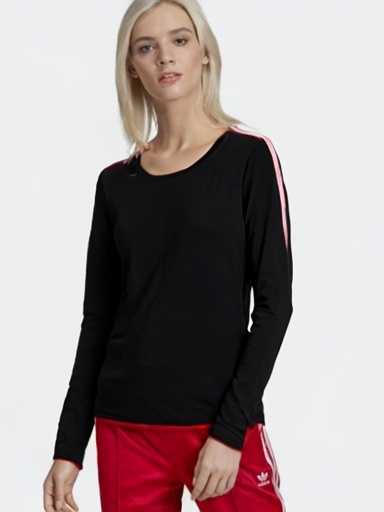

In [21]:
output = f'{img_output}/unpaired/upper_body'
img_name = os.listdir(output)[0]
Image.open(f'{output}/{img_name}')